In [27]:
!pip install pandas
!pip install scikit-learn 
!pip install openpyxl
!pip install matplotlib 
!pip install seaborn 
!pip install numpy 
!pip install statsmodels
!pip install lightgbm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")



Чтение и аналииз данных

In [28]:
train = pd.read_excel("train.xlsx")  
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [29]:
train.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [30]:
 # Преобразуем колонку с датой в формат datetime
train['dt'] = pd.to_datetime(train['dt'])

# Убеждаемся, что данные отсортированы по времени
train = train.sort_values(by='dt')


# Добавляем новые признаки
train["year"] = train["dt"].dt.year
train["month"] = train["dt"].dt.month
train["quarter"] = train["dt"].dt.quarter
train["day_of_month"] = train["dt"].dt.day
train["day_of_week"] = train["dt"].dt.weekday 

train = train.copy()


In [31]:
train.set_index('dt', inplace=True)

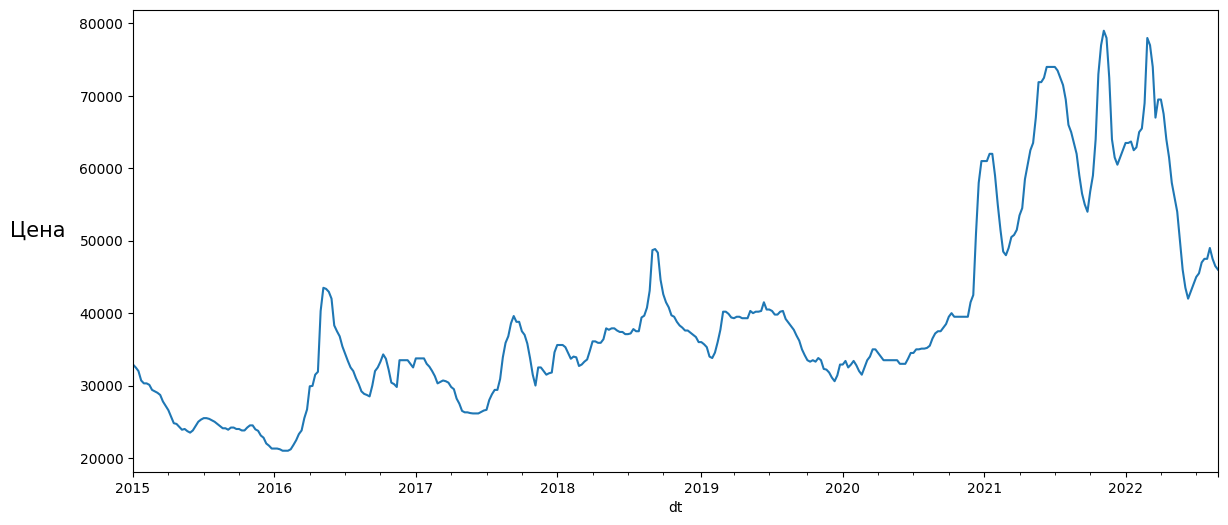

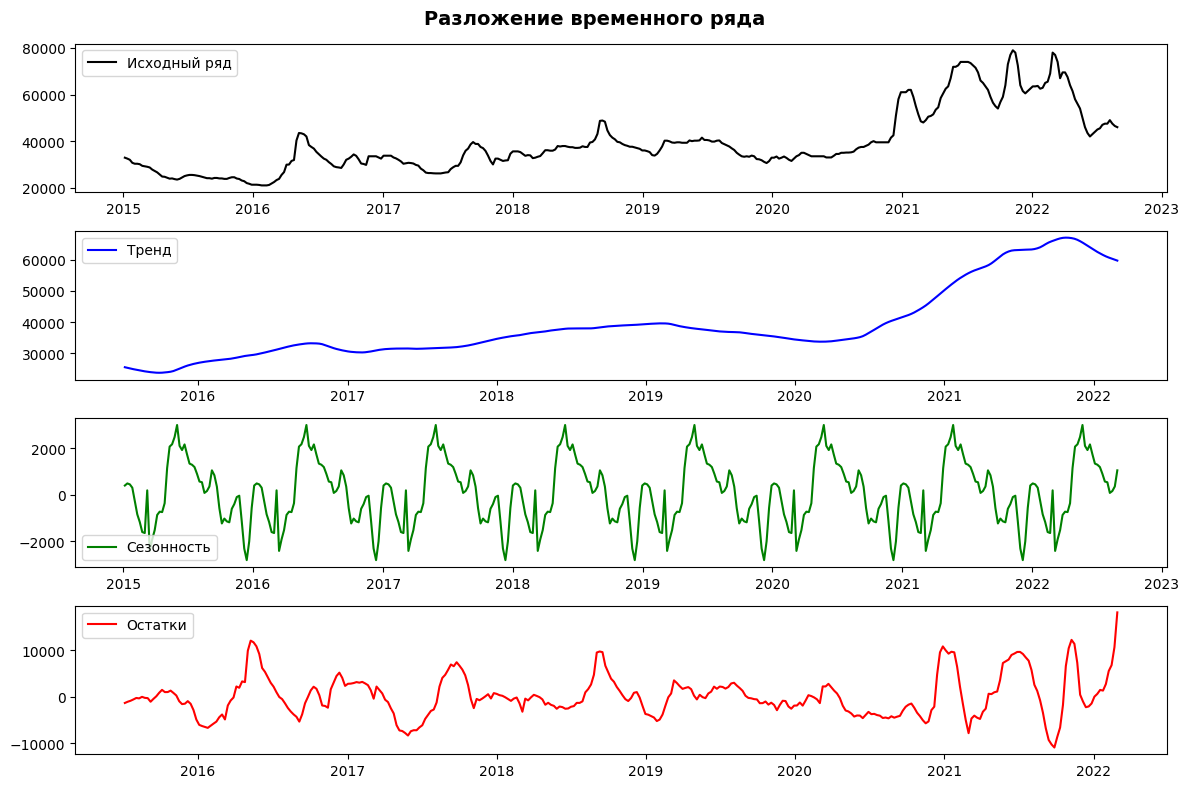

In [32]:
# Разложение временного ряда
decomposition = seasonal_decompose(train['Цена на арматуру'], model='additive', period=52)  # период ~1 год



# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
# plt.title('Time series example')
# plt.xlabel('Date', fontsize=15)
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=15)
train['Цена на арматуру'].plot()

plt.figure(figsize=(12, 8))
plt.suptitle("Разложение временного ряда", fontsize=14, fontweight='bold')

plt.subplot(4, 1, 1)
plt.plot(train['Цена на арматуру'], label='Исходный ряд', color='black')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Тренд', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Сезонность', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Остатки', color='red')
plt.legend()

plt.tight_layout()
plt.show()

Проверка стационарности

In [33]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    """
    Функция для проверки стационарности временного ряда с помощью теста Дики-Фуллера.
    
   
    """
    result = adfuller(series.dropna())  # Тест ADF, удаляем NaN перед проверкой
    print("Результаты теста Дики-Фуллера:")
    print(f"ADF-статистика: {result[0]:.4f}")
    print(f"p-значение: {result[1]:.4f}")
    print("Критические значения:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    # Интерпретация результатов
    if result[1] <= 0.05:
        print("\nРяд стационарен")
    else:
        print("\nРяд НЕ стационарен")

# Проверяем стационарность исходного ряда
test_stationarity(train['Цена на арматуру'])

Результаты теста Дики-Фуллера:
ADF-статистика: -1.9259
p-значение: 0.3200
Критические значения:
   1%: -3.4471
   5%: -2.8689
   10%: -2.5707

Ряд НЕ стационарен


Решение проблемы не стационарности

In [34]:
# Определяем окно скользящего стандартного отклонения
window = 12  # Например, 12 для месячных данных

# Копируем данные, чтобы не изменять оригинальный DataFrame
df_transformed = train.copy()

# Вычисляем скользящее стандартное отклонение
df_transformed['rolling_std'] = df_transformed['Цена на арматуру'].rolling(window=window).std()

# Нормализуем ряд, деля на скользящее стандартное отклонение
df_transformed['normalized_price'] = df_transformed['Цена на арматуру'] / df_transformed['rolling_std']

# Логарифмируем нормализованный ряд (добавляем небольшую константу, чтобы избежать log(0))
df_transformed['log_normalized_price'] = np.log(df_transformed['normalized_price'] + 1e-10)

# Дифференцируем логарифмированный ряд
df_transformed['stationary_price'] = df_transformed['log_normalized_price'].diff()

# Удаляем пропущенные значения, возникшие после вычислений
df_transformed = df_transformed.dropna()

# Выводим обработанный DataFrame
df_transformed


,Цена на арматуру,year,month,quarter,day_of_month,day_of_week,rolling_std,normalized_price,log_normalized_price,stationary_price
dt,,,,,,,,,,
2015-03-30,27200,2015,3,1,30,0,1556.413905,17.476071,2.860833,-0.012110
2015-04-06,26600,2015,4,2,6,0,1546.329966,17.202021,2.845027,-0.015806
2015-04-13,25700,2015,4,2,13,0,1605.388653,16.008585,2.773125,-0.071902
2015-04-20,24800,2015,4,2,20,0,1840.186914,13.476892,2.600977,-0.172149
2015-04-27,24700,2015,4,2,27,0,1980.109425,12.474058,2.523651,-0.077325
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,47500,2022,8,3,1,0,3320.049288,14.307017,2.660750,0.271592
2022-08-08,49000,2022,8,3,8,0,2461.829820,19.903894,2.990915,0.330165
2022-08-15,47500,2022,8,3,15,0,2165.063509,21.939310,3.088280,0.097365


In [35]:
from scipy.stats import boxcox

df_stationary = df_transformed.copy()

df_stationary['boxcox_price'], lambda_bc = boxcox(df_transformed['Цена на арматуру'] + 1)

# Дифференцируем Box-Cox преобразованный ряд
df_stationary['diff_boxcox_price'] = df_stationary['boxcox_price'].diff()

df_stationary.dropna(inplace=True)

test_stationarity(df_stationary['diff_boxcox_price'])

df_stationary.to_csv("train_ready.csv", index=True)


Результаты теста Дики-Фуллера:
ADF-статистика: -7.3460
p-значение: 0.0000
Критические значения:
   1%: -3.4477
   5%: -2.8692
   10%: -2.5708

Ряд стационарен


In [36]:
train_ready = pd.read_csv("train_ready.csv")

In [37]:
target = train_ready['Цена на арматуру'].dropna()

target_diff = target.diff().dropna()

# Тест Дики-Фуллера после дифференцирования
adf_result = adfuller(target_diff)
adf_p_value = adf_result[1]

adf_p_value

np.float64(6.261499049431979e-14)

Модель SARIMA

MAE: 11450.72
MSE: 190622114.30
RMSE: 13806.60
R²: -0.8455


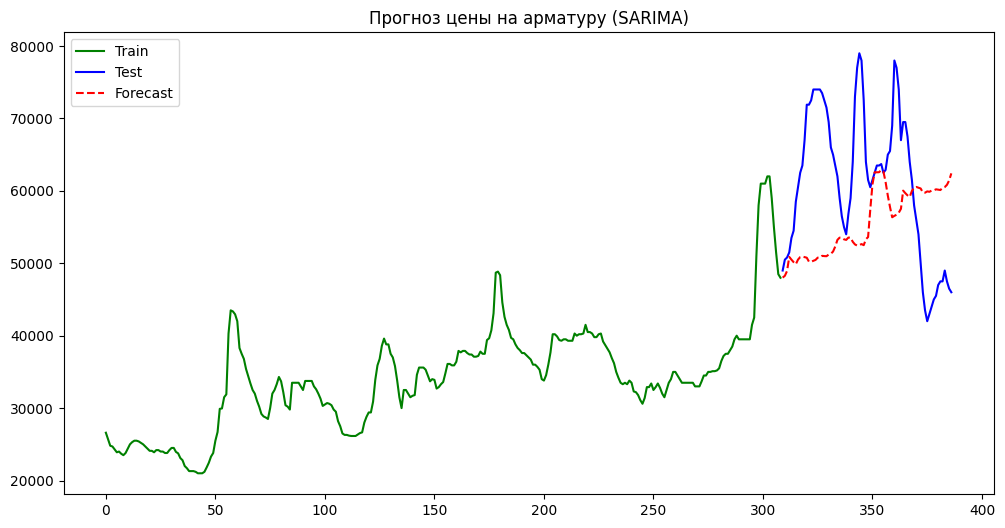

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Разложение на тренд и сезонность
decomposition = seasonal_decompose(train_ready['Цена на арматуру'], model='additive', period=52)
train_ready['trend'] = decomposition.trend
train_ready['seasonal'] = decomposition.seasonal

# Заполнение пропусков
for col in ['trend', 'seasonal']:
    train_ready[col] = train_ready[col].interpolate()

# Разделение данных на train и test
train_size = int(len(train_ready) * 0.8)
train_ready, test = train_ready.iloc[:train_size], train_ready.iloc[train_size:]

# Обучение модели SARIMA
model = SARIMAX(train_ready['Цена на арматуру'], order=(2,1,2), seasonal_order=(1,1,1,52))
model_fit = model.fit(disp=False)

# Прогнозирование
predictions = model_fit.predict(start=len(train_ready), end=len(train_ready) + len(test) - 1, dynamic=False)

# Оценка точности
mae = mean_absolute_error(test['Цена на арматуру'], predictions)
mse = mean_squared_error(test['Цена на арматуру'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test['Цена на арматуру'], predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_ready.index, train_ready['Цена на арматуру'], label='Train', color='green')
plt.plot(test.index, test['Цена на арматуру'], label='Test', color='blue')
plt.plot(test.index, predictions, label='Forecast', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (SARIMA)')
plt.legend()
plt.show()


In [39]:
!pip install lightgbm
!pip install optuna
import lightgbm as lgb
import optuna

Модель LightGBM №1

[I 2025-03-25 12:09:20,024] A new study created in memory with name: no-name-28da63b7-82ad-4bef-ba85-e5622b4f62cc
[I 2025-03-25 12:09:20,055] Trial 0 finished with value: 10076.69536950054 and parameters: {'learning_rate': 0.08647949846530831, 'num_leaves': 88, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.7819019951851249, 'colsample_bytree': 0.9849238550881438}. Best is trial 0 with value: 10076.69536950054.
[I 2025-03-25 12:09:20,069] Trial 1 finished with value: 12546.08184857559 and parameters: {'learning_rate': 0.16035721700087746, 'num_leaves': 13, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.6938231361531217, 'colsample_bytree': 0.7847517319353723}. Best is trial 0 with value: 10076.69536950054.
[I 2025-03-25 12:09:20,081] Trial 2 finished with value: 11062.110409497993 and parameters: {'learning_rate': 0.12876635792800267, 'num_leaves': 13, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.8598337619608503, 'colsample_bytree': 0.6531756644179935}. Bes

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 10076.7
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	valid_0's rmse: 12546.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 11062.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 12854.2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[121]	valid_0's rmse: 10951.6
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's rmse: 13964.4


[I 2025-03-25 12:09:20,190] Trial 6 finished with value: 13775.579003055193 and parameters: {'learning_rate': 0.10980262433169903, 'num_leaves': 86, 'max_depth': 6, 'min_child_samples': 39, 'subsample': 0.6813654846496187, 'colsample_bytree': 0.6606680048440399}. Best is trial 0 with value: 10076.69536950054.
[I 2025-03-25 12:09:20,232] Trial 7 finished with value: 10413.967303335265 and parameters: {'learning_rate': 0.03965476712598431, 'num_leaves': 13, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.5107291640892323, 'colsample_bytree': 0.5897796328832609}. Best is trial 0 with value: 10076.69536950054.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	valid_0's rmse: 13775.6
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[270]	valid_0's rmse: 10414


[I 2025-03-25 12:09:20,292] Trial 8 finished with value: 14175.765715303249 and parameters: {'learning_rate': 0.028116794877340312, 'num_leaves': 24, 'max_depth': 3, 'min_child_samples': 43, 'subsample': 0.539222051007784, 'colsample_bytree': 0.8067558811339661}. Best is trial 0 with value: 10076.69536950054.
[I 2025-03-25 12:09:20,312] Trial 9 finished with value: 14083.142924248184 and parameters: {'learning_rate': 0.1524260292218199, 'num_leaves': 96, 'max_depth': 4, 'min_child_samples': 31, 'subsample': 0.7703624502031674, 'colsample_bytree': 0.6938250357231102}. Best is trial 0 with value: 10076.69536950054.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 14175.8
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 14083.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 14105


[I 2025-03-25 12:09:20,368] Trial 10 finished with value: 14105.043676803512 and parameters: {'learning_rate': 0.0765666290258636, 'num_leaves': 67, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.9361318917493875, 'colsample_bytree': 0.9969483207434324}. Best is trial 0 with value: 10076.69536950054.


Training until validation scores don't improve for 50 rounds


[I 2025-03-25 12:09:20,450] Trial 11 finished with value: 9408.65809305899 and parameters: {'learning_rate': 0.07248946878289084, 'num_leaves': 45, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.5421650356696353, 'colsample_bytree': 0.508692074622937}. Best is trial 11 with value: 9408.65809305899.
[I 2025-03-25 12:09:20,519] Trial 12 finished with value: 10592.13789492726 and parameters: {'learning_rate': 0.07308468050434065, 'num_leaves': 44, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.7756632214432119, 'colsample_bytree': 0.5131924235567176}. Best is trial 11 with value: 9408.65809305899.


Early stopping, best iteration is:
[151]	valid_0's rmse: 9408.66
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 10592.1
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 12:09:20,607] Trial 13 finished with value: 7969.430498573545 and parameters: {'learning_rate': 0.0744981614086426, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.9759334244132967, 'colsample_bytree': 0.8766902654987943}. Best is trial 13 with value: 7969.430498573545.


Early stopping, best iteration is:
[95]	valid_0's rmse: 7969.43
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 12:09:20,657] Trial 14 finished with value: 13909.850146145893 and parameters: {'learning_rate': 0.18517354937730982, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.8923466081070306, 'colsample_bytree': 0.8833711684574301}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:20,720] Trial 15 finished with value: 11011.047498037085 and parameters: {'learning_rate': 0.05640076618870192, 'num_leaves': 48, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.9926445506525662, 'colsample_bytree': 0.8948658161912677}. Best is trial 13 with value: 7969.430498573545.


Early stopping, best iteration is:
[24]	valid_0's rmse: 13909.9
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 11011
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[462]	valid_0's rmse: 13432.4


[I 2025-03-25 12:09:20,805] Trial 16 finished with value: 13432.441718855831 and parameters: {'learning_rate': 0.1007945001545477, 'num_leaves': 34, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.5818820070682642, 'colsample_bytree': 0.511769244015856}. Best is trial 13 with value: 7969.430498573545.


Training until validation scores don't improve for 50 rounds

[I 2025-03-25 12:09:20,913] Trial 17 finished with value: 12629.14034595704 and parameters: {'learning_rate': 0.010753179853133968, 'num_leaves': 74, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.985299730977975, 'colsample_bytree': 0.8505815619866658}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:21,006] Trial 18 finished with value: 9254.9718889386 and parameters: {'learning_rate': 0.058569707743954806, 'num_leaves': 57, 'max_depth': 6, 'min_child_samples': 6, 'subsample': 0.5640225319508885, 'colsample_bytree': 0.6096178857853218}. Best is trial 13 with value: 7969.430498573545.



Early stopping, best iteration is:
[330]	valid_0's rmse: 12629.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's rmse: 9254.97
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 12:09:21,064] Trial 19 finished with value: 14229.151519617546 and parameters: {'learning_rate': 0.05330082208705611, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.7222067545843682, 'colsample_bytree': 0.6136575872609645}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:21,118] Trial 20 finished with value: 10849.819349626481 and parameters: {'learning_rate': 0.10055716754926865, 'num_leaves': 79, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.9297786385582333, 'colsample_bytree': 0.5698885558721383}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:21,204] Trial 21 finished with value: 9388.70607975408 and parameters: {'learning_rate': 0.060330276797914854, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.5680120735533001, 'colsample_bytree': 0.5243100462029038}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:21,266] Trial 22 finished with value: 10137

Early stopping, best iteration is:
[104]	valid_0's rmse: 14229.2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 10849.8
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[182]	valid_0's rmse: 9388.71
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's rmse: 10137.9


[I 2025-03-25 12:09:21,373] Trial 23 finished with value: 9340.137241117573 and parameters: {'learning_rate': 0.061016391436488605, 'num_leaves': 53, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.6345672317795467, 'colsample_bytree': 0.630598371478007}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:21,432] Trial 24 finished with value: 11652.695253410908 and parameters: {'learning_rate': 0.08982806747755266, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.6368715364122738, 'colsample_bytree': 0.6359862825413821}. Best is trial 13 with value: 7969.430498573545.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	valid_0's rmse: 9340.14
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 11652.7
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 12:09:21,573] Trial 25 finished with value: 9960.642050514918 and parameters: {'learning_rate': 0.015790343712291356, 'num_leaves': 62, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.5030167186077048, 'colsample_bytree': 0.6966365252268524}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:21,638] Trial 26 finished with value: 13445.007532058804 and parameters: {'learning_rate': 0.04668184225566674, 'num_leaves': 76, 'max_depth': 8, 'min_child_samples': 21, 'subsample': 0.6698408225993907, 'colsample_bytree': 0.9273831342878626}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:21,704] Trial 27 finished with value: 10775.379701440004 and parameters: {'learning_rate': 0.11659710371859539, 'num_leaves': 68, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.8174225052098638, 'colsample_bytree': 0.7960429442804162}. Best is trial 13 with value: 7969.430498573545.


Early stopping, best iteration is:
[283]	valid_0's rmse: 9960.64
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's rmse: 13445
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 10775.4
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 12:09:21,781] Trial 28 finished with value: 11669.39317583152 and parameters: {'learning_rate': 0.06539093724888284, 'num_leaves': 56, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.734847649515054, 'colsample_bytree': 0.7369113995791496}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:21,863] Trial 29 finished with value: 8887.40257596321 and parameters: {'learning_rate': 0.08331900131685396, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.6078366219307172, 'colsample_bytree': 0.8416318378718486}. Best is trial 13 with value: 7969.430498573545.
[I 2025-03-25 12:09:21,930] Trial 30 finished with value: 9939.133876410873 and parameters: {'learning_rate': 0.08550159146557566, 'num_leaves': 99, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.7160653110710945, 'colsample_bytree': 0.8377272584383024}. Best is trial 13 with value: 7969.430498573545.


Early stopping, best iteration is:
[54]	valid_0's rmse: 11669.4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 8887.4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 9939.13
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 12:09:22,023] Trial 31 finished with value: 7771.029589353483 and parameters: {'learning_rate': 0.08216528098494477, 'num_leaves': 92, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.6179850223648131, 'colsample_bytree': 0.9088506498301852}. Best is trial 31 with value: 7771.029589353483.
[I 2025-03-25 12:09:22,088] Trial 32 finished with value: 7701.285185553664 and parameters: {'learning_rate': 0.08992047464980699, 'num_leaves': 93, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.5454258910919039, 'colsample_bytree': 0.9582181242652492}. Best is trial 32 with value: 7701.285185553664.
[I 2025-03-25 12:09:22,146] Trial 33 finished with value: 9630.179531332658 and parameters: {'learning_rate': 0.08990952342503471, 'num_leaves': 93, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.6134082514082808, 'colsample_bytree': 0.9439728946317634}. Best is trial 32 with value: 7701.285185553664.


Early stopping, best iteration is:
[73]	valid_0's rmse: 7771.03
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's rmse: 7701.29
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 9630.18
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 11722.7


[I 2025-03-25 12:09:22,196] Trial 34 finished with value: 11722.660174606735 and parameters: {'learning_rate': 0.12115032973258741, 'num_leaves': 92, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.5364048499657856, 'colsample_bytree': 0.9027653353407562}. Best is trial 32 with value: 7701.285185553664.
[I 2025-03-25 12:09:22,262] Trial 35 finished with value: 10575.013245743254 and parameters: {'learning_rate': 0.08202506319912516, 'num_leaves': 83, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.5974417311188909, 'colsample_bytree': 0.8482740257311676}. Best is trial 32 with value: 7701.285185553664.
[I 2025-03-25 12:09:22,324] Trial 36 finished with value: 10917.124743884486 and parameters: {'learning_rate': 0.0976120041659568, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.8080096803687621, 'colsample_bytree': 0.9626067522161923}. Best is trial 32 with value: 7701.285185553664.
[I 2025-03-25 12:09:22,376] Trial 37 finished with value: 13

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 10575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	valid_0's rmse: 10917.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 13365.2
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 12:09:22,462] Trial 38 finished with value: 7575.469105794661 and parameters: {'learning_rate': 0.11147266436026591, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6522612231712577, 'colsample_bytree': 0.926888256150368}. Best is trial 38 with value: 7575.469105794661.
[I 2025-03-25 12:09:22,518] Trial 39 finished with value: 12516.42269345026 and parameters: {'learning_rate': 0.11242698287411931, 'num_leaves': 84, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.6654694200934969, 'colsample_bytree': 0.9295974075584288}. Best is trial 38 with value: 7575.469105794661.
[I 2025-03-25 12:09:22,575] Trial 40 finished with value: 10950.474717811137 and parameters: {'learning_rate': 0.1390227438548228, 'num_leaves': 80, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.648238799299721, 'colsample_bytree': 0.9733556925334249}. Best is trial 38 with value: 7575.469105794661.


Early stopping, best iteration is:
[55]	valid_0's rmse: 7575.47
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 12516.4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 10950.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[81]	valid_0's rmse: 10309


[I 2025-03-25 12:09:22,655] Trial 41 finished with value: 10309.007230696488 and parameters: {'learning_rate': 0.09456504904409378, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 7, 'subsample': 0.6150337368437833, 'colsample_bytree': 0.9171723422540915}. Best is trial 38 with value: 7575.469105794661.
[I 2025-03-25 12:09:22,756] Trial 42 finished with value: 8868.231285690357 and parameters: {'learning_rate': 0.10512259641894833, 'num_leaves': 94, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.5567128112968992, 'colsample_bytree': 0.8168838033523242}. Best is trial 38 with value: 7575.469105794661.
[I 2025-03-25 12:09:22,818] Trial 43 finished with value: 10647.55788105256 and parameters: {'learning_rate': 0.10547215292045145, 'num_leaves': 86, 'max_depth': 10, 'min_child_samples': 10, 'subsample': 0.5560236988659275, 'colsample_bytree': 0.8185037260941611}. Best is trial 38 with value: 7575.469105794661.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's rmse: 8868.23
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	valid_0's rmse: 10647.6
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 12:09:22,890] Trial 44 finished with value: 10427.6405410233 and parameters: {'learning_rate': 0.12423825591462691, 'num_leaves': 73, 'max_depth': 11, 'min_child_samples': 7, 'subsample': 0.5242468519932297, 'colsample_bytree': 0.7628733322555852}. Best is trial 38 with value: 7575.469105794661.
[I 2025-03-25 12:09:22,952] Trial 45 finished with value: 13864.85137506924 and parameters: {'learning_rate': 0.10956848968183966, 'num_leaves': 93, 'max_depth': 10, 'min_child_samples': 34, 'subsample': 0.8633660153545301, 'colsample_bytree': 0.875456908903625}. Best is trial 38 with value: 7575.469105794661.
[I 2025-03-25 12:09:23,020] Trial 46 finished with value: 10511.190091672292 and parameters: {'learning_rate': 0.07028801087492627, 'num_leaves': 81, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.576778049639932, 'colsample_bytree': 0.9571401143418783}. Best is trial 38 with value: 7575.469105794661.
[I 2025-03-25 12:09:23,088] Trial 47 finished with value: 10280.

Early stopping, best iteration is:
[49]	valid_0's rmse: 10427.6
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's rmse: 13864.9
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 10511.2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 10280.6


[I 2025-03-25 12:09:23,145] Trial 48 finished with value: 11525.74072938644 and parameters: {'learning_rate': 0.17498453181460222, 'num_leaves': 77, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.5219706192594351, 'colsample_bytree': 0.9044388283424676}. Best is trial 38 with value: 7575.469105794661.
[I 2025-03-25 12:09:23,209] Trial 49 finished with value: 14113.996776390588 and parameters: {'learning_rate': 0.07686937297942623, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 41, 'subsample': 0.690423925568173, 'colsample_bytree': 0.8170006217960258}. Best is trial 38 with value: 7575.469105794661.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 11525.7
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[150]	valid_0's rmse: 14114
Лучшие параметры: {'learning_rate': 0.11147266436026591, 'num_leaves': 82, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6522612231712577, 'colsample_bytree': 0.926888256150368}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 5.73877e+07
MAE: 5361.71
MSE: 57387732.17
RMSE: 7575.47
R²: 0.4412


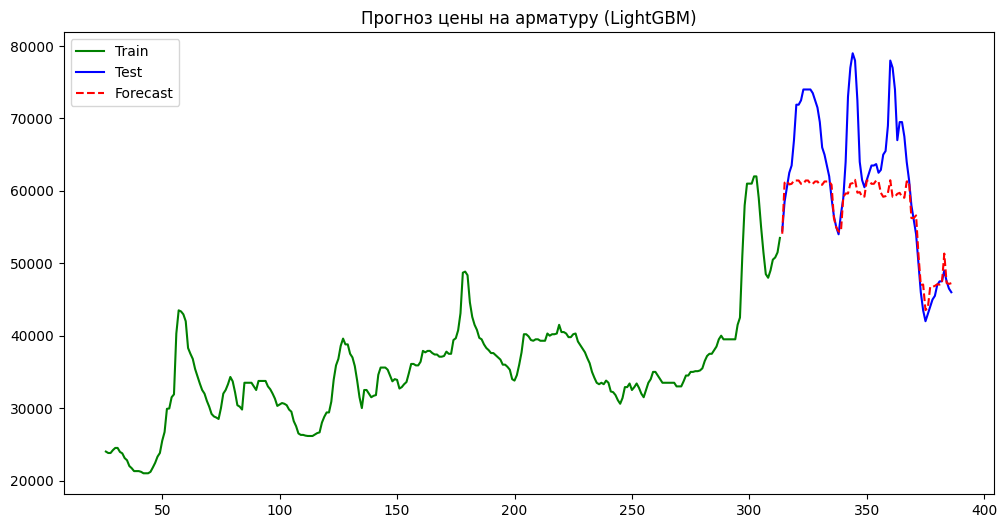

In [40]:
df = pd.read_csv("train_ready.csv", parse_dates=['dt'])

# Обработка стационарности (разложение на тренд и сезонность)
decomposition = seasonal_decompose(df['Цена на арматуру'], model='additive', period=52)
df['trend'] = decomposition.trend
df['seasonal'] = decomposition.seasonal

# Заполнение пропусков
df['trend'].interpolate(inplace=True)
df['seasonal'].interpolate(inplace=True)

# Количество временных лагов
lag_features = 12

for i in range(1, lag_features + 1):
    df[f"lag_{i}"] = df["Цена на арматуру"].shift(i)

df.dropna(inplace=True)  # Убираем пропущенные значения

# Выбираем целевую переменную и признаки
target_col = "Цена на арматуру"
feature_cols = [col for col in df.columns if col not in ["dt", target_col]]

# Разделяем данные на train/test
train_size = 0.8
train_df, test_df = train_test_split(df, test_size=1-train_size, shuffle=False)

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# Создаём датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'min_child_samples': trial.suggest_int("min_child_samples", 5, 50),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'feature_pre_filter': False,
        'verbose': -1
    }

    model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(50)])

    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

# Запуск Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Лучшие параметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение финальной модели
best_params["verbose"] = -1
final_model = lgb.train(best_params, train_data, num_boost_round=500, valid_sets=[test_data],
                        callbacks=[lgb.early_stopping(50)])

# Прогноз
final_predictions = final_model.predict(X_test)

# Оценка точности
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, final_predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, y_train, label='Train', color='green')
plt.plot(test_df.index, y_test, label='Test', color='blue')
plt.plot(test_df.index, final_predictions, label='Forecast', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (LightGBM)')
plt.legend()
plt.show()


Добавление фичей

In [41]:
df['rolling_mean_3'] = df["Цена на арматуру"].rolling(window=3).mean()
df['rolling_mean_6'] = df["Цена на арматуру"].rolling(window=6).mean()
df['rolling_mean_12'] = df["Цена на арматуру"].rolling(window=12).mean()

df['price_diff_1'] = df["Цена на арматуру"].diff(1)
df['price_diff_3'] = df["Цена на арматуру"].diff(3)

df['ewm_6'] = df["Цена на арматуру"].ewm(span=6, adjust=False).mean()
df['ewm_12'] = df["Цена на арматуру"].ewm(span=12, adjust=False).mean()

df.fillna(0, inplace=True)

print(df.head())

           dt  Цена на арматуру  year  month  quarter  day_of_month  \
26 2015-10-05             24000  2015     10        4             5   
27 2015-10-12             23800  2015     10        4            12   
28 2015-10-19             23800  2015     10        4            19   
29 2015-10-26             24200  2015     10        4            26   
30 2015-11-02             24500  2015     11        4             2   

    day_of_week  rolling_std  normalized_price  log_normalized_price  ...  \
26            0   514.045158         46.688505              3.843498  ...   
27            0   443.129368         53.708921              3.983579  ...   
28            0   361.394605         65.855991              4.187470  ...   
29            0   255.247948         94.809773              4.551872  ...   
30            0   217.422923        112.683611              4.724584  ...   

     lag_10   lag_11   lag_12  rolling_mean_3  rolling_mean_6  \
26  25200.0  25400.0  25500.0        0.000000

In [42]:
features = [
    "rolling_mean_3", "rolling_mean_6", "rolling_mean_12",
    "price_diff_1", "price_diff_3", "ewm_6", "ewm_12"
]

target = "Цена на арматуру"

X = df[features]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)


(288, 7) (73, 7)
(288,) (73,)


Матрица корреляции

In [43]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# corr_matrix = df.corr()
# plt.figure(figsize=(20, 10))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Корреляция признаков")
# plt.show()


Модель LightGBM №2

[I 2025-03-25 13:25:52,986] A new study created in memory with name: no-name-ac1b913c-ecbc-4061-9044-9e3cef06ac40


[I 2025-03-25 13:25:53,041] Trial 0 finished with value: 11067.366561808247 and parameters: {'learning_rate': 0.18012295140536438, 'num_leaves': 50, 'max_depth': 9, 'min_child_samples': 45, 'subsample': 0.6252313568877979, 'colsample_bytree': 0.6279823827767359}. Best is trial 0 with value: 11067.366561808247.
[I 2025-03-25 13:25:53,127] Trial 1 finished with value: 11186.303422631487 and parameters: {'learning_rate': 0.03734498493822964, 'num_leaves': 75, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.8391824737711857, 'colsample_bytree': 0.8545279498150982}. Best is trial 0 with value: 11067.366561808247.
[I 2025-03-25 13:25:53,166] Trial 2 finished with value: 8140.975986816113 and parameters: {'learning_rate': 0.17532501117291677, 'num_leaves': 67, 'max_depth': 7, 'min_child_samples': 31, 'subsample': 0.6844167923907278, 'colsample_bytree': 0.751241327345733}. Best is trial 2 with value: 8140.975986816113.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 11067.4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[193]	valid_0's rmse: 11186.3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 8140.98
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 13:25:53,299] Trial 3 finished with value: 10490.354628200354 and parameters: {'learning_rate': 0.04859013857921441, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 36, 'subsample': 0.9795799371010032, 'colsample_bytree': 0.7159491403511028}. Best is trial 2 with value: 8140.975986816113.
[I 2025-03-25 13:25:53,368] Trial 4 finished with value: 3987.245317273764 and parameters: {'learning_rate': 0.07431529815609889, 'num_leaves': 10, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.9348970791815063, 'colsample_bytree': 0.8912213826126633}. Best is trial 4 with value: 3987.245317273764.
[I 2025-03-25 13:25:53,419] Trial 5 finished with value: 7575.49780950681 and parameters: {'learning_rate': 0.09405767818795784, 'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.6240178456082341, 'colsample_bytree': 0.5294829602185749}. Best is trial 4 with value: 3987.245317273764.
[I 2025-03-25 13:25:53,474] Trial 6 finished with value: 4355.68401180

Early stopping, best iteration is:
[105]	valid_0's rmse: 10490.4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 3987.25
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's rmse: 7575.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 4355.68
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 4457.55


[I 2025-03-25 13:25:53,540] Trial 8 finished with value: 11230.740181505582 and parameters: {'learning_rate': 0.1048979087453148, 'num_leaves': 48, 'max_depth': 7, 'min_child_samples': 45, 'subsample': 0.620978161304802, 'colsample_bytree': 0.5987715394682707}. Best is trial 4 with value: 3987.245317273764.
[I 2025-03-25 13:25:53,624] Trial 9 finished with value: 5128.1176509806055 and parameters: {'learning_rate': 0.04276032249035993, 'num_leaves': 43, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.6838374735759358, 'colsample_bytree': 0.7413682792976906}. Best is trial 4 with value: 3987.245317273764.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 11230.7
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's rmse: 5128.12
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 13:25:53,715] Trial 10 finished with value: 6747.167082981318 and parameters: {'learning_rate': 0.0776169300884556, 'num_leaves': 14, 'max_depth': 12, 'min_child_samples': 21, 'subsample': 0.8464621736765106, 'colsample_bytree': 0.9814197442219483}. Best is trial 4 with value: 3987.245317273764.
[I 2025-03-25 13:25:53,797] Trial 11 finished with value: 4016.2696476066926 and parameters: {'learning_rate': 0.14433301116004787, 'num_leaves': 12, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.7991291382305101, 'colsample_bytree': 0.8552103021492575}. Best is trial 4 with value: 3987.245317273764.
[I 2025-03-25 13:25:53,866] Trial 12 finished with value: 3896.1838417375648 and parameters: {'learning_rate': 0.1367321295666344, 'num_leaves': 10, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.8586994741984882, 'colsample_bytree': 0.8489525686262979}. Best is trial 12 with value: 3896.1838417375648.


Early stopping, best iteration is:
[47]	valid_0's rmse: 6747.17
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 4016.27
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 3896.18
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 13:25:53,974] Trial 13 finished with value: 4718.776573180136 and parameters: {'learning_rate': 0.06911888975736041, 'num_leaves': 26, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.8797214813128517, 'colsample_bytree': 0.8680960395679886}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:54,134] Trial 14 finished with value: 4714.633506893218 and parameters: {'learning_rate': 0.015790533485625174, 'num_leaves': 25, 'max_depth': 5, 'min_child_samples': 15, 'subsample': 0.9121513464139983, 'colsample_bytree': 0.801436366963711}. Best is trial 12 with value: 3896.1838417375648.


Early stopping, best iteration is:
[52]	valid_0's rmse: 4718.78
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[235]	valid_0's rmse: 4714.63
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 13:25:54,218] Trial 15 finished with value: 4579.8966436776445 and parameters: {'learning_rate': 0.12395462464664937, 'num_leaves': 11, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.5158490417403487, 'colsample_bytree': 0.9228262054850098}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:54,300] Trial 16 finished with value: 7521.505706681468 and parameters: {'learning_rate': 0.12482887830290451, 'num_leaves': 26, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.9224239957027552, 'colsample_bytree': 0.9215830037755444}. Best is trial 12 with value: 3896.1838417375648.


Early stopping, best iteration is:
[24]	valid_0's rmse: 4579.9
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 7521.51
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 4009.65


[I 2025-03-25 13:25:54,403] Trial 17 finished with value: 4009.6456613678097 and parameters: {'learning_rate': 0.19596235330445044, 'num_leaves': 37, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.7868444291348962, 'colsample_bytree': 0.992351236656798}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:54,500] Trial 18 finished with value: 6382.779338962278 and parameters: {'learning_rate': 0.08046458301598318, 'num_leaves': 81, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.9338012801530529, 'colsample_bytree': 0.8047877267824008}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:54,573] Trial 19 finished with value: 8290.101645456612 and parameters: {'learning_rate': 0.12721679811351755, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.858965133653611, 'colsample_bytree': 0.6849093705646254}. Best is trial 12 with value: 3896.1838417375648.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 6382.78
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[52]	valid_0's rmse: 8290.1
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 13:25:54,678] Trial 20 finished with value: 4692.823859489479 and parameters: {'learning_rate': 0.05877665227842807, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.7833391769854258, 'colsample_bytree': 0.7910966756789372}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:54,745] Trial 21 finished with value: 4006.1944555664177 and parameters: {'learning_rate': 0.1942350420099696, 'num_leaves': 35, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.812816980925843, 'colsample_bytree': 0.9947509648278549}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:54,798] Trial 22 finished with value: 4177.6988890603825 and parameters: {'learning_rate': 0.16445522629303397, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 8, 'subsample': 0.8909931926189011, 'colsample_bytree': 0.8834474116341198}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:54,851] Trial 23 finished with value: 39

Early stopping, best iteration is:
[64]	valid_0's rmse: 4692.82
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 4006.19
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 4177.7
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 3917.84


[I 2025-03-25 13:25:54,965] Trial 24 finished with value: 4670.860289558451 and parameters: {'learning_rate': 0.09230864026687632, 'num_leaves': 18, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.9556092661516646, 'colsample_bytree': 0.9408453034778155}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:55,026] Trial 25 finished with value: 4035.2981396529362 and parameters: {'learning_rate': 0.11058080364675388, 'num_leaves': 10, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.9530151289549388, 'colsample_bytree': 0.8955291942103163}. Best is trial 12 with value: 3896.1838417375648.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 4670.86
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 4035.3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 4774.84


[I 2025-03-25 13:25:55,117] Trial 26 finished with value: 4774.841240622583 and parameters: {'learning_rate': 0.10970847744920642, 'num_leaves': 27, 'max_depth': 10, 'min_child_samples': 12, 'subsample': 0.9857995293283046, 'colsample_bytree': 0.8286397346343628}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:55,256] Trial 27 finished with value: 5264.844856436779 and parameters: {'learning_rate': 0.026030396742064532, 'num_leaves': 19, 'max_depth': 12, 'min_child_samples': 17, 'subsample': 0.8980970507404928, 'colsample_bytree': 0.9562876213814612}. Best is trial 12 with value: 3896.1838417375648.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's rmse: 5264.84
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 3999.66


[I 2025-03-25 13:25:55,379] Trial 28 finished with value: 3999.6618946131375 and parameters: {'learning_rate': 0.06415613700560584, 'num_leaves': 97, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8703586864743049, 'colsample_bytree': 0.903884145168995}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:55,447] Trial 29 finished with value: 11376.027362517343 and parameters: {'learning_rate': 0.08458632443454978, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 50, 'subsample': 0.7431899778204849, 'colsample_bytree': 0.832537212955919}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:55,509] Trial 30 finished with value: 7147.880885291614 and parameters: {'learning_rate': 0.16370230138653552, 'num_leaves': 16, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.9437881304509431, 'colsample_bytree': 0.9622586877226819}. Best is trial 12 with value: 3896.1838417375648.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[113]	valid_0's rmse: 11376
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 7147.88
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 3971.03


[I 2025-03-25 13:25:55,631] Trial 31 finished with value: 3971.0318197154083 and parameters: {'learning_rate': 0.06359078271187991, 'num_leaves': 93, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.8632134991532968, 'colsample_bytree': 0.9026027992896908}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:55,727] Trial 32 finished with value: 4383.216415964046 and parameters: {'learning_rate': 0.05775041820218252, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 10, 'subsample': 0.8352567251873063, 'colsample_bytree': 0.8939397702471638}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:55,805] Trial 33 finished with value: 4074.874213828475 and parameters: {'learning_rate': 0.09874709381585531, 'num_leaves': 82, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.9973446812938822, 'colsample_bytree': 0.8220468237938415}. Best is trial 12 with value: 3896.1838417375648.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 4383.22
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 4074.87
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 13:25:55,906] Trial 34 finished with value: 4674.0919245314235 and parameters: {'learning_rate': 0.07299028592951531, 'num_leaves': 70, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.8283301676578332, 'colsample_bytree': 0.863317425040004}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:56,012] Trial 35 finished with value: 10454.803984859524 and parameters: {'learning_rate': 0.03871010177880471, 'num_leaves': 42, 'max_depth': 12, 'min_child_samples': 35, 'subsample': 0.906630166293353, 'colsample_bytree': 0.962196609395066}. Best is trial 12 with value: 3896.1838417375648.


Early stopping, best iteration is:
[51]	valid_0's rmse: 4674.09
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	valid_0's rmse: 10454.8
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 13:25:56,116] Trial 36 finished with value: 3908.7774368833725 and parameters: {'learning_rate': 0.08927645199474898, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9548308765948569, 'colsample_bytree': 0.9135650905925882}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:56,182] Trial 37 finished with value: 5331.099837049197 and parameters: {'learning_rate': 0.11538763520434016, 'num_leaves': 60, 'max_depth': 6, 'min_child_samples': 18, 'subsample': 0.9571179400117544, 'colsample_bytree': 0.7734221178761115}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:56,251] Trial 38 finished with value: 4054.888673901437 and parameters: {'learning_rate': 0.08752401071022864, 'num_leaves': 92, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.7593189951230706, 'colsample_bytree': 0.6741120128140323}. Best is trial 12 with value: 3896.1838417375648.


Early stopping, best iteration is:
[28]	valid_0's rmse: 3908.78
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 5331.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 4054.89
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 4678.25


[I 2025-03-25 13:25:56,308] Trial 39 finished with value: 4678.251910889279 and parameters: {'learning_rate': 0.1339523222215308, 'num_leaves': 73, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.8709279707401087, 'colsample_bytree': 0.9180653371323446}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:56,369] Trial 40 finished with value: 4385.101703934034 and parameters: {'learning_rate': 0.09859263881428075, 'num_leaves': 79, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.9720897614665784, 'colsample_bytree': 0.9432992151940025}. Best is trial 12 with value: 3896.1838417375648.
[I 2025-03-25 13:25:56,447] Trial 41 finished with value: 3891.027416613132 and parameters: {'learning_rate': 0.0550791919719274, 'num_leaves': 62, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9222242260686663, 'colsample_bytree': 0.8766366605439159}. Best is trial 41 with value: 3891.027416613132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 4385.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 3891.03
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 3898.18


[I 2025-03-25 13:25:56,523] Trial 42 finished with value: 3898.1838709765752 and parameters: {'learning_rate': 0.05528382857274782, 'num_leaves': 62, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9221186856625239, 'colsample_bytree': 0.8463095691781194}. Best is trial 41 with value: 3891.027416613132.
[I 2025-03-25 13:25:56,610] Trial 43 finished with value: 3903.833027974255 and parameters: {'learning_rate': 0.0419188445238891, 'num_leaves': 61, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9236592735225746, 'colsample_bytree': 0.847723797680419}. Best is trial 41 with value: 3891.027416613132.
[I 2025-03-25 13:25:56,682] Trial 44 finished with value: 4059.6382331638233 and parameters: {'learning_rate': 0.05215327033047587, 'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 8, 'subsample': 0.92761539640997, 'colsample_bytree': 0.7529409113285388}. Best is trial 41 with value: 3891.027416613132.
[I 2025-03-25 13:25:56,741] Trial 45 finished with value: 4707.166407

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 3903.83
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 4059.64
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[130]	valid_0's rmse: 4707.17


[I 2025-03-25 13:25:56,818] Trial 46 finished with value: 8012.979040469629 and parameters: {'learning_rate': 0.04278949149190779, 'num_leaves': 50, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.9240819855026697, 'colsample_bytree': 0.8561485405798215}. Best is trial 41 with value: 3891.027416613132.
[I 2025-03-25 13:25:56,936] Trial 47 finished with value: 4341.723985916746 and parameters: {'learning_rate': 0.015855032459677967, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 10, 'subsample': 0.5557645932528947, 'colsample_bytree': 0.8705876465579272}. Best is trial 41 with value: 3891.027416613132.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's rmse: 8012.98
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's rmse: 4341.72
Training until validation scores don't improve for 50 rounds


[I 2025-03-25 13:25:57,006] Trial 48 finished with value: 4133.237268274197 and parameters: {'learning_rate': 0.03170207864865973, 'num_leaves': 68, 'max_depth': 5, 'min_child_samples': 7, 'subsample': 0.683676587603218, 'colsample_bytree': 0.5624681143983592}. Best is trial 41 with value: 3891.027416613132.
[I 2025-03-25 13:25:57,079] Trial 49 finished with value: 11102.083823599867 and parameters: {'learning_rate': 0.04648453054728914, 'num_leaves': 44, 'max_depth': 7, 'min_child_samples': 43, 'subsample': 0.8854493725274424, 'colsample_bytree': 0.7681148905474214}. Best is trial 41 with value: 3891.027416613132.


Early stopping, best iteration is:
[78]	valid_0's rmse: 4133.24
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	valid_0's rmse: 11102.1
Лучшие параметры: {'learning_rate': 0.0550791919719274, 'num_leaves': 62, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.9222242260686663, 'colsample_bytree': 0.8766366605439159}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 1.51401e+07
MAE: 2844.45
MSE: 15140094.36
RMSE: 3891.03
R²: 0.8597


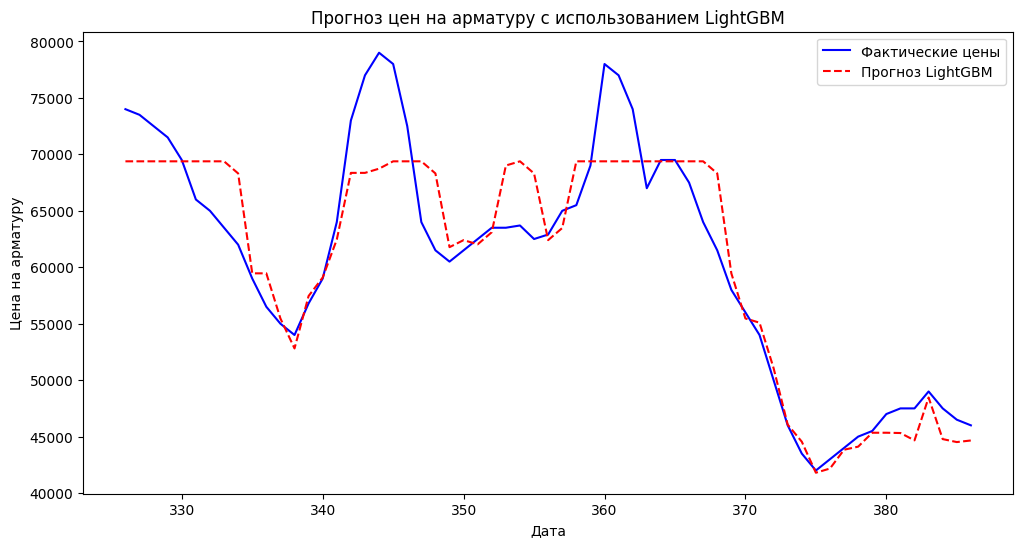

In [49]:
df = pd.read_csv("train_ready.csv", parse_dates=['dt'])

# Количество временных лагов
lag_features = 12
for i in range(1, lag_features + 1):
    df[f"lag_{i}"] = df["Цена на арматуру"].shift(i)

# Добавляем скользящие средние
df["rolling_mean_3"] = df["Цена на арматуру"].rolling(3).mean()
df["rolling_mean_6"] = df["Цена на арматуру"].rolling(6).mean()
df["rolling_mean_12"] = df["Цена на арматуру"].rolling(12).mean()

# Добавляем экспоненциальное сглаживание
df["ewm_6"] = df["Цена на арматуру"].ewm(span=6).mean()
df["ewm_12"] = df["Цена на арматуру"].ewm(span=12).mean()

# Добавляем разности цен
df["diff_1"] = df["Цена на арматуру"].diff(1)
df["diff_3"] = df["Цена на арматуру"].diff(3)

df = df.dropna()  

# Выбираем целевую переменную и признаки
target_col = "Цена на арматуру"
feature_cols = [col for col in df.columns if col not in ["dt", target_col]]

# Разделяем данные на train/test
train_size = 0.84
train_df, test_df = train_test_split(df, test_size=1-train_size, shuffle=False)

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# Создаём датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'min_child_samples': trial.suggest_int("min_child_samples", 5, 50),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'feature_pre_filter': False,
        'verbose': -1
    }

    model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(50)])
    
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

# Запуск Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Лучшие параметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение финальной модели с лучшими параметрами
best_params["verbose"] = -1
final_model = lgb.train(best_params, train_data, num_boost_round=500, valid_sets=[test_data],
                        callbacks=[lgb.early_stopping(50)])

# Прогнозируем
final_predictions = final_model.predict(X_test)

# Оценка точности
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, final_predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация прогнозов
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, y_test, label='Фактические цены', color='blue')
plt.plot(test_df.index, final_predictions, label='Прогноз LightGBM', color='red', linestyle='--')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз цен на арматуру с использованием LightGBM")
plt.legend()
plt.show()

In [50]:
mape = np.mean(np.abs((y_test - final_predictions) / y_test)) * 100

accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Точность модели: {accuracy:.2f}%")


MAPE: 4.38%
Точность модели: 95.62%


In [46]:
import pickle

model_filename = "lightgbm_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(final_model, file)

print(f"Модель сохранена в {model_filename}")


Модель сохранена в lightgbm_model.pkl
